In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tools.cpc import ConstantProductCurve as CPC, CPCContainer, T, CPCInverter, Pair
from tools.optimizer import CPCArbOptimizer, F, MargPOptimizer, PairOptimizer
from tools.analyzer import CPCAnalyzer
#print("{0.__name__} v{0.__VERSION__} ({0.__DATE__})".format(Pair))
print("{0.__name__} v{0.__VERSION__} ({0.__DATE__})".format(CPC))
#print("{0.__name__} v{0.__VERSION__} ({0.__DATE__})".format(CPCArbOptimizer))
print("{0.__name__} v{0.__VERSION__} ({0.__DATE__})".format(MargPOptimizer))
#print("{0.__name__} v{0.__VERSION__} ({0.__DATE__})".format(PairOptimizer))

plt.style.use('seaborn-v0_8-dark')
plt.rcParams['figure.figsize'] = [12,6]

ConstantProductCurve v3.4 (12/Dec/2023)
MargPOptimizer v5.2.1 (11/Dec/2023)


# Optimizer Testing [202312a-THOR Triangle]

**IMPORTANT NOTE** 

For the above imports to work, you must create a symlink to the `tools` module here, running

    ln -s ../../fastlane_bot/tools tools
    
Don't forget to add a local `.gitignore` file in this case!

## Reading input data

Set `curves_as_dicts` to the output of `CPCContainer.as_dicts`. The use `CPCContainer.from_dicts` to recreate a container.

In [2]:
curves_as_dicts = [{'k': 4.3078885616238194e+24,
  'x': 1250505254484.4102,
  'x_act': 0,
  'y_act': 344491.8061533139,
  'alpha': 0.5,
  'pair': 'USDC-eB48/THOR-8044',
  'cid': '74181555988764585035015664420125470098056-1',
  'fee': 2000.0,
  'descr': 'carbon_v1 THOR-8044/USDC-eB48 2000',
  'constr': 'carb',
  'params': {'exchange': 'carbon_v1',
   'tknx_dec': 18,
   'tkny_dec': 6,
   'tknx_addr': '0xa5f2211B9b8170F694421f2046281775E8468044',
   'tkny_addr': '0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48',
   'blocklud': 18758319,
   'y': 344491.8061533139,
   'yint': 344491.8061533139,
   'A': 0,
   'B': 1.659765242784964,
   'pa': 2.754820936639097,
   'pb': 2.754820936639097}},
 {'k': 1106096356.8039548,
  'x': 2619874.8519412754,
  'x_act': 2619874.8519412754,
  'y_act': 422.1943487049999,
  'alpha': 0.5,
  'pair': 'THOR-8044/WETH-6Cc2',
  'cid': '0xbf1875da0431343b56ec6295f706e257dbe85696e5270a5bdad005d37cc2fd9c',
  'fee': 0.003,
  'descr': 'sushiswap_v2 THOR-8044/WETH-6Cc2 0.003',
  'constr': 'uv2',
  'params': {'exchange': 'sushiswap_v2',
   'tknx_dec': 18,
   'tkny_dec': 18,
   'tknx_addr': '0xa5f2211B9b8170F694421f2046281775E8468044',
   'tkny_addr': '0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2',
   'blocklud': 18758340}},
 {'k': 1233376864385.0625,
  'x': 54102579.539405,
  'x_act': 54102579.539405,
  'y_act': 22797.00662861641,
  'alpha': 0.5,
  'pair': 'USDC-eB48/WETH-6Cc2',
  'cid': '0x68bd2250b4b44996e193e9e001f74a5e5a31b31fbd0bb7df34c66eb8da7e6be2',
  'fee': 3000.0,
  'descr': 'uniswap_v2 USDC-eB48/WETH-6Cc2 0.003',
  'constr': 'uv2',
  'params': {'exchange': 'uniswap_v2',
   'tknx_dec': 6,
   'tkny_dec': 18,
   'tknx_addr': '0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48',
   'tkny_addr': '0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2',
   'blocklud': 18758413}}]

In [3]:
CC = CPCContainer.from_dicts(curves_as_dicts)
len(CC), len(curves_as_dicts)

(3, 3)

## Analyzis and visualization

Note: THOR ~ 30c

### Visualization

pair = USDC/WETH


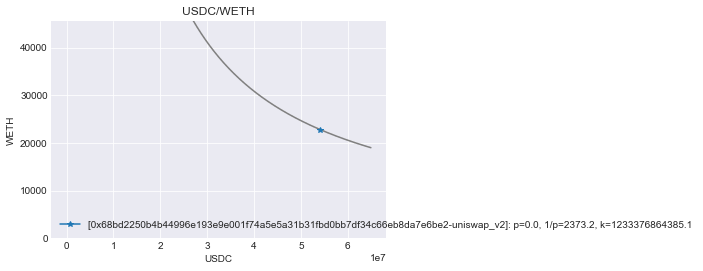

pair = USDC/THOR


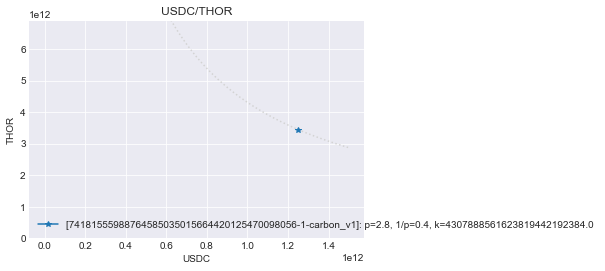

pair = THOR/WETH


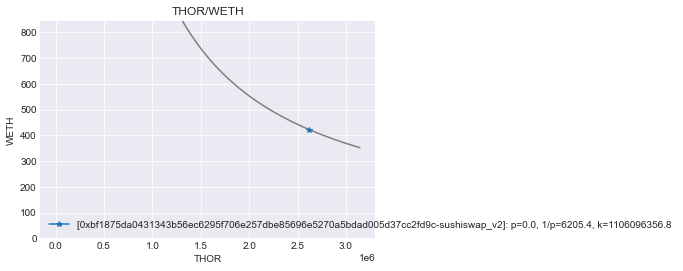

In [4]:
CC.plot()

### Analysis

In [5]:
sgn = [1,-1,-1]
price = dict()
quote = dict()
for c,s in zip(CC, sgn):
    price[c.pair] = c.p
    quotep = f"{c.tkny} per {c.tknx}" if s > 0 else f"{c.tknx} per {c.tkny}"
    print(f"{c.pair} {s} {(c.p)**s} {quotep}")

USDC-eB48/THOR-8044 1 2.754821212121191 THOR-8044 per USDC-eB48
THOR-8044/WETH-6Cc2 -1 6205.376410123059 THOR-8044 per WETH-6Cc2
USDC-eB48/WETH-6Cc2 -1 2373.231732603509 USDC-eB48 per WETH-6Cc2


In [6]:
price

{'USDC-eB48/THOR-8044': 2.754821212121191,
 'THOR-8044/WETH-6Cc2': 0.0001611505787737007,
 'USDC-eB48/WETH-6Cc2': 0.00042136635300378734}

### Carbon curve

Below is the Carbon curve. It **sells THOR** and **buys USDC** at a rate of **0.36 USDC per THOR** (ignoring fees).

In [7]:
p0 = 1/(price["USDC-eB48/THOR-8044"])
p0

0.3629999637000064

In [8]:
print(CC[0].description())

cid      = 098056-1 [74181555988764585035015664420125470098056-1]
primary  = THOR/USDC [THOR-8044/USDC-eB48]
pp       = 0.363000 USDC per THOR
pair     = USDC/THOR [USDC-eB48/THOR-8044]
tknx     =             0.000000 USDC-eB48  [virtual: 1,250,505,254,484.410]
tkny     =       344,491.806153 THOR-8044  [virtual: 3,444,918,400,922.661]
p        = 2.754821212121191 [min=2.7548206611570305, max=2.754821212121191] THOR-8044 per USDC-eB48
fee      = 2000.0
descr    = carbon_v1 THOR-8044/USDC-eB48 2000



Ignoring slippage and fees, it is possible to buy and sell THOR AT 0.38 USDC per THOR via the two provided curves.

In [9]:
p1 = 1/(price["USDC-eB48/WETH-6Cc2"] / price["THOR-8044/WETH-6Cc2"])
p1

0.3824476672731679

That's an arbitrage opportunity (Buy THOR against USDC on Carbon, sell into the arb) of about 5% meaning that at least in small size (ie before slippage) it should work

In [10]:
p1/p0-1

0.05357494633039028

### Triangle curves

The triangle curves are the following

- **THOR/WETH** has 422 ETH and 2.6m THOR at a price of 6205 THOR per ETH
- **WETH/USDC** has 23k ETH and 50m USDC at a price of 2373 USDC per ETH

The implied **THOR** price is 0.382 USDC (memo: on Carbon it is 0.362, and the THOR loading is 344k, ie ~15% of the THOR available on the arb curve)

In [11]:
p1, p0, p1/p0-1, 344/2600

(0.3824476672731679,
 0.3629999637000064,
 0.05357494633039028,
 0.13230769230769232)

In [12]:
print(CC[1].description())

cid      = 7cc2fd9c [0xbf1875da0431343b56ec6295f706e257dbe85696e5270a5bdad005d37cc2fd9c]
primary  = THOR/WETH [THOR-8044/WETH-6Cc2]
pp       = 0.000161 WETH per THOR
pair     = THOR/WETH [THOR-8044/WETH-6Cc2]
tknx     =     2,619,874.851941 THOR-8044  [virtual:        2,619,874.852]
tkny     =           422.194349 WETH-6Cc2  [virtual:              422.194]
p        = 0.0001611505787737007 [min=0, max=None] WETH-6Cc2 per THOR-8044
fee      = 0.003
descr    = sushiswap_v2 THOR-8044/WETH-6Cc2 0.003



In [13]:
1/0.0001611505787737007

6205.376410123059

In [14]:
print(CC[2].description())

cid      = da7e6be2 [0x68bd2250b4b44996e193e9e001f74a5e5a31b31fbd0bb7df34c66eb8da7e6be2]
primary  = WETH/USDC [WETH-6Cc2/USDC-eB48]
pp       = 2,373.231733 USDC per WETH
pair     = USDC/WETH [USDC-eB48/WETH-6Cc2]
tknx     =    54,102,579.539405 USDC-eB48  [virtual:       54,102,579.539]
tkny     =        22,797.006629 WETH-6Cc2  [virtual:           22,797.007]
p        = 0.00042136635300378734 [min=0, max=None] WETH-6Cc2 per USDC-eB48
fee      = 3000.0
descr    = uniswap_v2 USDC-eB48/WETH-6Cc2 0.003



In [15]:
1/0.00042136635300378734

2373.231732603509

## Optimizer

### Raw run

This is the actual run, using USDC as the arbitrage token. This run does not converge; rather the THOR/USDC price oscillates between 0.38ish and 0.29ish. Note that this is way out of the (imputed) price range for the Carbon range which is very tightly centered around `p0~0.36`

(uncomment the below code to see the debug run)

In [16]:
O = MargPOptimizer(CC)
r = O.optimize("USDC-eB48", params=dict(verbose=False, debug=False))
#O.optimize("USDC-eB48", params=dict(verbose=True, debug=True))
r

CPCArbOptimizer.MargpOptimizerResult(result=None, time=0.015214204788208008, method='margp', targettkn='USDC-eB48', p_optimal_t=None, dtokens_t=None, tokens_t=('WETH-6Cc2', 'THOR-8044'), errormsg=ConvergenceError('maximum number of iterations reached [49]'))

In [17]:
#r = O.optimize("USDC-eB48", params=dict(verbose=True, debug=True))
#r

### Better prices estimates

We set the initial price for THOR/USD squat into the Carbon range to see whether thise works better. 

TLDR -- it does not. Shame.

In [18]:
price_est = {
    "USDC-eB48": 1,
    "WETH-6Cc2": 2373.2,
    "THOR-8044": p0,
}
price_est

{'USDC-eB48': 1, 'WETH-6Cc2': 2373.2, 'THOR-8044': 0.3629999637000064}

In [19]:
O = MargPOptimizer(CC)
r = O.optimize("USDC-eB48", params=dict(pstart=price_est, verbose=False, debug=False))
#O.optimize("USDC-eB48", params=dict(pstart=price_est, verbose=True, debug=True))
r

CPCArbOptimizer.MargpOptimizerResult(result=None, time=0.011157035827636719, method='margp', targettkn='USDC-eB48', p_optimal_t=None, dtokens_t=None, tokens_t=('WETH-6Cc2', 'THOR-8044'), errormsg=ConvergenceError('maximum number of iterations reached [49]'))

### Adding a regularization curve

The issue with the convergence is that the Carbon range is very thin, and the gradients from the other curves just jump across it. Unfortunately this happens both ways so we always jump from one side of the curve to the other, without ever converging.

One way to solve this is to add a Uni v2 style curve with the same characteristics (price, mostly) as the Carbon curve. This curve should guide the algo more smoothly back into the Carbon range (provided the v2 curve is big enough to affect the gradient, and not too big to distort the result).

Note the following convergence properties with respect to the `SCALING` parameter (note: both x and y of the initial curve are divided by this factor)

- `SCALING = 60` converges
- `SCALING = 65` does not converge

**HOWEVER CONVERGENCE DOES NOT LEAD TO THE CORRECT POINT; D_TOKEN [THOR] IS STILL NOT ZERO**

In [20]:
SCALING = 50

In [21]:
c0d = curves_as_dicts[0]
c0d

{'k': 4.3078885616238194e+24,
 'x': 1250505254484.4102,
 'x_act': 0,
 'y_act': 344491.8061533139,
 'alpha': 0.5,
 'pair': 'USDC-eB48/THOR-8044',
 'cid': '74181555988764585035015664420125470098056-1',
 'fee': 2000.0,
 'descr': 'carbon_v1 THOR-8044/USDC-eB48 2000',
 'constr': 'carb',
 'params': {'exchange': 'carbon_v1',
  'tknx_dec': 18,
  'tkny_dec': 6,
  'tknx_addr': '0xa5f2211B9b8170F694421f2046281775E8468044',
  'tkny_addr': '0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48',
  'blocklud': 18758319,
  'y': 344491.8061533139,
  'yint': 344491.8061533139,
  'A': 0,
  'B': 1.659765242784964,
  'pa': 2.754820936639097,
  'pb': 2.754820936639097}}

In [22]:
c0 = CC[0]
c0

ConstantProductCurve(k=4.3078885616238194e+24, x=1250505254484.4102, x_act=0, y_act=344491.8061533139, alpha=0.5, pair='USDC-eB48/THOR-8044', cid='74181555988764585035015664420125470098056-1', fee=2000.0, descr='carbon_v1 THOR-8044/USDC-eB48 2000', constr='carb', params={'exchange': 'carbon_v1', 'tknx_dec': 18, 'tkny_dec': 6, 'tknx_addr': '0xa5f2211B9b8170F694421f2046281775E8468044', 'tkny_addr': '0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48', 'blocklud': 18758319, 'y': 344491.8061533139, 'yint': 344491.8061533139, 'A': 0, 'B': 1.659765242784964, 'pa': 2.754820936639097, 'pb': 2.754820936639097})

In [23]:
c0r = CPC.from_xy(x=c0.x/SCALING, y=c0.y/SCALING, pair=c0.pair)
c0r

ConstantProductCurve(k=1.7231554246495277e+21, x=25010105089.6882, x_act=25010105089.6882, y_act=68898368018.45322, alpha=0.5, pair='USDC-eB48/THOR-8044', cid='None', fee=None, descr=None, constr='xy', params={})

In [24]:
1/c0.p, 1/c0r.p

(0.3629999637000064, 0.3629999637000064)

In [25]:
CCr = CPCContainer.from_dicts(curves_as_dicts)
CCr += c0r

pair = USDC/WETH


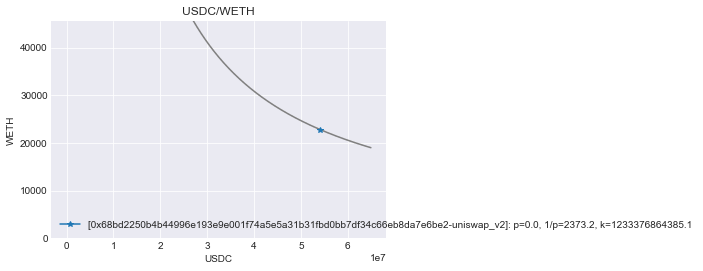

pair = USDC/THOR


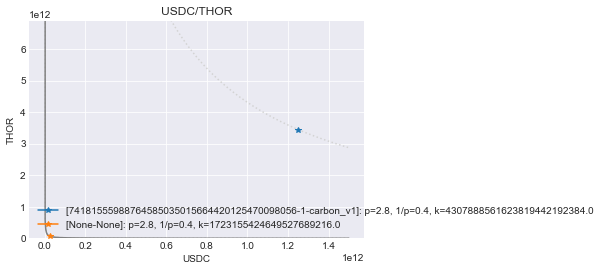

pair = THOR/WETH


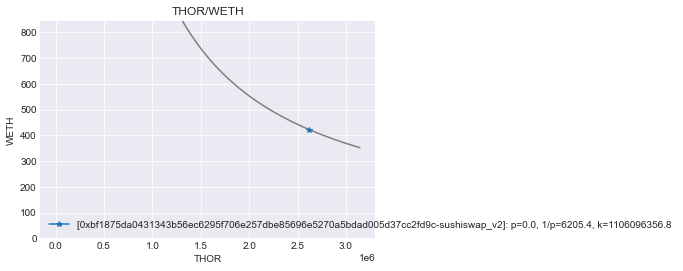

In [26]:
CCr.plot()

In [27]:
O = MargPOptimizer(CCr)
r = O.optimize("USDC-eB48", params=dict(verbose=False, debug=False))
#O.optimize("USDC-eB48", params=dict(verbose=True, debug=True))
r

CPCArbOptimizer.MargpOptimizerResult(result=109076.49614349008, time=0.0014920234680175781, method='margp', targettkn='USDC-eB48', p_optimal_t=(2371.009327956787, 0.363000235520445), dtokens_t=(-5.535582658922067e-09, -302284.11119448347), tokens_t=('WETH-6Cc2', 'THOR-8044'), errormsg=None)

In [28]:
p2 = r.p_optimal["THOR-8044"]
p2

0.363000235520445

In [29]:
p2/p0-1

7.488167101943333e-07

In [30]:
r.dtokens

{'WETH-6Cc2': -5.535582658922067e-09,
 'THOR-8044': -302284.11119448347,
 'USDC-eB48': 109076.49614349008}

### Removing the Carbon curve

Here we check how it converges if we remove the Carbon curve and replace it with a constant product curve of the same (virtual) capacity. Unsurprisingly it does and all dtokens are zero.

In [31]:
c0 = CC[0]
c0b = CPC.from_xy(x=c0.x, y=c0.y, pair=c0.pair)
c0b

ConstantProductCurve(k=4.3078885616238194e+24, x=1250505254484.4102, x_act=1250505254484.4102, y_act=3444918400922.661, alpha=0.5, pair='USDC-eB48/THOR-8044', cid='None', fee=None, descr=None, constr='xy', params={})

pair = USDC/WETH


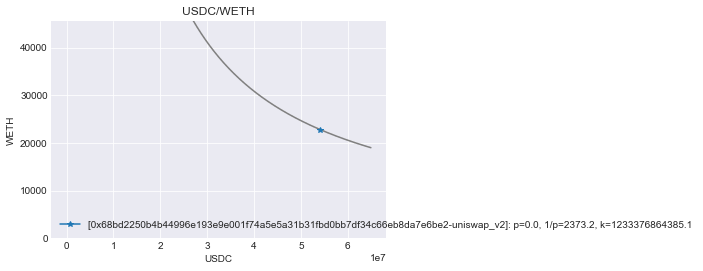

pair = USDC/THOR


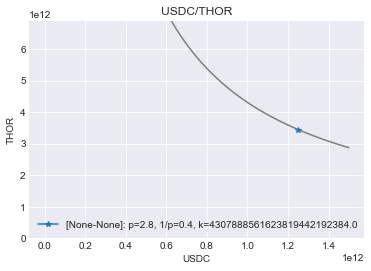

pair = THOR/WETH


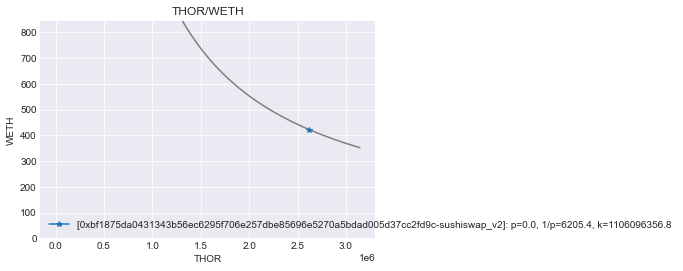

In [32]:
CCb = CPCContainer.from_dicts(curves_as_dicts[1:])
CCb += c0b
CCb.plot()

In [33]:
O = MargPOptimizer(CCb)
r = O.optimize("USDC-eB48", params=dict(verbose=False, debug=False))
#O.optimize("USDC-eB48", params=dict(verbose=True, debug=True))
r

CPCArbOptimizer.MargpOptimizerResult(result=-652.6406125426292, time=0.0006477832794189453, method='margp', targettkn='USDC-eB48', p_optimal_t=(2371.0092981594016, 0.36299997803167794), dtokens_t=(-5.344651299310499e-08, -0.000662557315081358), tokens_t=('WETH-6Cc2', 'THOR-8044'), errormsg=None)

In [34]:
r.dtokens

{'WETH-6Cc2': -5.344651299310499e-08,
 'THOR-8044': -0.000662557315081358,
 'USDC-eB48': -652.6406125426292}

## Unit tests

In [35]:
def iseq(arg0, *args, eps=1e-6):
    """checks whether all arguments are equal to arg0, within tolerance eps if numeric"""
    if not args:
        raise ValueError("Must provide at least one arg", args)
    try:
        arg0+1
        isnumeric = True
    except:
        isnumeric = False
    #if isinstance(arg0, int) or isinstance(arg0, float):
    if isnumeric:
        # numeric testing
        if arg0 == 0:
            for arg in args:
                if abs(arg) > eps: 
                    return False
                return True
        for arg in args:
            if abs(arg/arg0-1) > eps:
                return False
            return True
    else:
        for arg in args:
            if not arg == arg0:
                return False
        return True

def raises(func, *args, **kwargs):
    """
    returns exception message if func(*args, **kwargs) raises, else False

    USAGE

        assert raises(func, 1, 3, three=3), "func(1, 2, three=3) should raise"
    """
    try:
        func(*args, **kwargs)
        return False
    except Exception as e:
        return str(e)

### min range width functionality

In [36]:
cdata = dict(y=100, yint=100, pa=100, pb=100, pair="WETH/USDC", tkny="USDC")
c  = CPC.from_carbon(**cdata)
c2 = CPC.from_carbon(**cdata, minrw=1e-2)
c4 = CPC.from_carbon(**cdata, minrw=1e-4)
c6 = CPC.from_carbon(**cdata, minrw=1e-6)
c

ConstantProductCurve(k=400000399924037.75, x=2000000.4998099068, x_act=0, y_act=100, alpha=0.5, pair='WETH/USDC', cid='None', fee=None, descr=None, constr='carb', params={'y': 100, 'yint': 100, 'A': 0, 'B': 9.999997500001562, 'pa': 100, 'pb': 100, 'minrw': 1e-06})

In [43]:
assert c2.params.minrw==0.01
assert c4.params.minrw==0.0001
assert c6.params.minrw==0.000001
assert c.params.minrw==0.000001

In [37]:
assert iseq(c2.p**2/100**2, 1.01)
assert iseq(c4.p**2/100**2, 1.0001)
assert iseq(c6.p**2/100**2, 1.000001)
assert iseq(c.p, c6.p)

In [38]:
assert iseq(c2.p-100, 0.49875621120, eps=1e-3)
assert iseq(c4.p-100, 0.00499987500, eps=1e-3)
assert iseq(c6.p-100, 0.00004999875, eps=1e-3)
assert iseq((c2.p-100)/(c4.p-100), 99.75373596136635, eps=1e-4)
assert iseq((c4.p-100)/(c6.p-100), 99.99752507444194, eps=1e-4)

0.01